In [1]:
## based on https://dynetworkx.readthedocs.io/en/latest/tutorial.html
import dynetworkx as dnx
import networkx as nx

import numpy as np
from numpy.random import PCG64
# use matplotlib to visualize graph?
# see https://www.geeksforgeeks.org/python-visualize-graphs-generated-in-networkx-using-matplotlib/
%matplotlib notebook        
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   # plot in 3D

######## IMPORT MY OWN MODULES ########
from trajectory import *          # import the simulator loop 
from plotStates_updated import *          # import module to plot % time each arm is in each state


In [2]:
### environment constants
x_lim    = [0.2, 0.9]
y_lim    = [0., 10.]
z_lim    = [0., 2.7]

# for the fruit distribution, want to keep it the same for these tests
x_seed = PCG64(37428395352013185889194479428694397783)
y_seed = PCG64(13250124924871709375127216220749555998)
z_seed = PCG64(165440185943501291848242755689690423219)

# density of "fruit" in the orchard
density = 10


### robot constants
n_arm  = 3   # K in melon paper
n_cell = 3   # keeping it simple for now

total_arms = n_arm*n_cell

# vehicle speed
v = 0.1   # in m/s 

# 'fruit handling time window,' a constant worst case value (for now)
Tw_con = 5.     # in sec

# cell width/height (perpendicular to movement) and length (parallel to movement)
cell_h = (z_lim[1] - z_lim[0]) / n_cell  # w in paper
cell_l = 0.3                  # length of individual arm cell 

# arm starting locations
arm_location = np.zeros([n_cell, n_arm, 3])
offset       = 0.2

arm_location[:,:,0] = 0. # x-coordinate start
arm_location[:,:,1] = np.linspace(0, n_arm*offset, n_arm, endpoint=True)

for n in range(n_cell):
    arm_location[n,:,2] = 0. + n*cell_h # z-coordinate start
    
    
# for k in range(n_arm):
#     # set the arms at their respective starting y-coord locations based on offset
#     arm_location[k,1] = k*offset # y-coordinate start -> assumes #0 is at the back, rest of code doesn't
    
# print(arm_location)

In [3]:
## Interval graph node setup
class fruitNode:
    def __init__(self, i, j, k, n, t): 
        # ith fruit
        self.i  = i
        # jth fruit picked by this arm
        self.j  = j
        # arm for which edges are being calculated
        self.k  = k
        # arm's pool/horizontal row
        self.n  = n
        # jth fruit i that the arm k has picked up, denoted t^{k}_{i(j)}, previous fruit 
        # would be t^{k}_{i(j-1)}
        # time at which kth arm reaches the jth fruit it has picked up
        self.t  = t 

In [4]:
## Functions
def calcTm(traj_calc, start_y, start_z, fruit_y, fruit_z):
    '''
       Calculate Tm (moving time -> move in y,z to next fruit) for node i for arm k.
    '''
    # arm settings
    v_max = 0.8
    a_max = 3.1
    d_max = a_max
    
    # calculate move in y-axis
    traj_calc.adjInit(start_y, 0.) # start moving from zero speed
    traj_calc.noJerkProfile(traj_calc.q0, fruit_y, traj_calc.v0, v_max, a_max, d_max)
    
    t_y = traj_calc.Ta + traj_calc.Tv + traj_calc.Td 
    
    # calculate conveyor drop off
    traj_calc.adjInit(start_z, 0.) 
    traj_calc.noJerkProfile(traj_calc.q0, fruit_z, traj_calc.v0, v_max, a_max, d_max)
    
    t_z = traj_calc.Ta + traj_calc.Tv + traj_calc.Td 
    
    # calculate which will dominate
    Tm = max(t_y, t_z)
    
    return(Tm)


def calcTw(traj_calc, fruit_x, fruit_z, bottom_z):
    '''
       Calculate handling time -> extension + pick time + retraction + conveyor drop off 
       for node i. Seperated into two values, before picking (Td0) and after picking (Td1) 
    '''
    # constants
    t_grab = 0.1 
    # arm settings
    v_max = 0.8
    a_max = 3.1
    d_max = a_max
    
    # calculate extension (retraction)
    traj_calc.adjInit(0., 0.)      # starts at zero for x each time (extend to fruit)
    traj_calc.noJerkProfile(traj_calc.q0, fruit_x, traj_calc.v0, v_max, a_max, d_max)
    
    t_x = traj_calc.Ta + traj_calc.Tv + traj_calc.Td 
    
    # calculate conveyor drop off
    traj_calc.adjInit(fruit_z, 0.) # starts at fruit's location (move to conveyor from fruit)
    traj_calc.noJerkProfile(traj_calc.q0, bottom_z, traj_calc.v0, v_max, a_max, d_max)
    
    t_z = traj_calc.Ta + traj_calc.Tv + traj_calc.Td 
    
    # add them together to get before picking and after picking
    Td0 = t_grab + t_x
    Td1 = t_x + t_z
    
    return([Td0, Td1])


def intervalGraph(k, ystart, ystop, color='b'):
    '''Interval graph of the edges with given k arm and color.''' 
    # plot the interval
    plt.hlines(k, ystart, ystop, color, lw=4)
    # plots the whiskers/ends
    plt.vlines(ystart, k+0.03, k-0.03, color, lw=2)
    plt.vlines(ystop, k+0.03, k-0.03, color, lw=2)


In [5]:
## Create fruit data set
len_x = x_lim[1] - x_lim[0]            
len_y = y_lim[1] - y_lim[0]  
len_z = z_lim[1] - z_lim[0]

numFruit = int(density * (len_y*len_x*len_z))  

x = np.random.default_rng(x_seed).uniform(x_lim[0], x_lim[1], numFruit)
y = np.random.default_rng(y_seed).uniform(y_lim[0], y_lim[1], numFruit)
z = np.random.default_rng(z_seed).uniform(z_lim[0], z_lim[1], numFruit)

# need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
fruit = np.stack([x, y, z])

axis_to_sort = np.argsort(y) # sort based on y-axis
sortedFruit = fruit[:,axis_to_sort]

# print(sortedFruit)

# create an array (or list if it'll need to be dynamic later) for node objects
# node_array  = np.ndarray(numFruit+n_arm, dtype=object)  # numFruit+arm_node for the initial dummy nodes for each arm
node_array  = np.ndarray(numFruit+total_arms, dtype=object)  # numFruit+arm_node for the initial dummy nodes for each arm

In [6]:
## Initialize the interval graph
IG = dnx.IntervalGraph()

# arm settings, also in calcTd function
v_max = 0.8
a_max = 3.1
d_max = a_max

t_grab = 0.1

## initialize the ability to calculate trajectory
traj_calc = Trajectory(v_max, a_max, d_max)

In [7]:
## (a) initialize dummy 0 nodes for each arm k in each horizontal row
n = -1
for k in range(total_arms): 
    k_pool = k % n_arm
    if k_pool == 0:
        n += 1
#     print('n:', n, 'k_pool:', k_pool)
    
    # node array's index will go from k = 0, 1, ... , total_arms (all the 0th values for each arm)
    node_array[k] = fruitNode(0, 0, k_pool, n, 0)
    IG.add_node(node_array[k])
    
# IG.nodes(data=True) # show the attributes for each node (maybe not necessary)
print('did the dummy node for k=1 get created?', IG.has_node(node_array[1]))
print('k value for dummy node for k=1 (should be = 1):', node_array[1].k)

# set all fruit as unpicked
for i in range(numFruit):
#     node_array[i+n_arm] = fruitNode(i, 0, n_arm, 0) # k = n_arm which is > n-1 (index) to identify unpicked fruit
    node_array[i+total_arms] = fruitNode(i, 0, n_arm, n_cell, 0) # k = n_arm which is > n-1 (index) to identify unpicked fruit
    # actual fruit will also be set to non-existent pool (n_cell > range(n_cell))
#     IG.add_node(node_array[i+n_arm])
    IG.add_node(node_array[i+total_arms])
    
print('number of fruit:', numFruit)    
print('number of nodes after adding all zero nodes for the arms:', len(IG.nodes()))

did the dummy node for k=1 get created? True
k value for dummy node for k=1 (should be = 1): 1
number of fruit: 189
number of nodes after adding all zero nodes for the arms: 198


In [8]:
'''
   Creating time intervals for each fruit for each arm in the cell based on fruit location: when the arm 
   can pick it and how long extension+grab+retract+drop off of fruit will take without running through fruit 
   list for every pool/horizontal row
'''
# figure out what fruit get matched to each row based on z-axis location
edge_list = list()
k_edges   = list()
Tw_values = list() # the same value for every arm, separated into Tw0 (extend+grab) and Tw1 (retract+drop off)

# edges for the nth horizontal row of cells
# row bottom edge = n*cell_h
row_bot_edge = np.linspace(0, (n_cell*cell_h - cell_h), n_cell, endpoint=True)
# row_top_edge = row_bot_edge + cell_h
row_top_edge = np.copy(row_bot_edge) + cell_h
# print('each bottom frame z-val:', row_bot_edge)
# print('each top frame z-val:', row_top_edge)

for n in range(n_cell):
    edge_list.append([])
#     Tw_values.append([]) 
    
for index, y_i in enumerate(sortedFruit[1]):
    # check that the zi value is available to the nth horizontal row of cells
        
    ## calculate pool/horizontal, n, row value by comparing zi vs cell height 
    n = math.floor(sortedFruit[2,index] / cell_h)
#     print(n)

    ## can set fruit node's pool value here:
    node_array[index+total_arms].n = n
    
    # calculate y_i / v which is constant for this fruit

    # handling time will be constant here, based on the pool's/row's bottom edge
    [Tw0, Tw1] = calcTw(traj_calc, sortedFruit[0,index], sortedFruit[2,index], row_bot_edge[n])
    Tw_values.append([Tw0, Tw1]) # save values since it will be used to calc picking time later
    ## Tw based on fruit i, and it will be based on which horizontal row it fits in (row_bot_edge[n]) but 
    #   not saved by row (n)

    Tw = Tw0 + Tw1

    # values of fruit location at the start and end, as well as the handling time
    t_start_0 = y_i / v - Tw # adding the calculated handling time 
    t_end_0   = y_i / v      # the end time will be when the back frame is reached by the fruit 

    k_edges.append(index)

    for k in range(n_arm):
        # add the offset based on the arm number (assuming back arm is k=0 to front arm k=n_arm)
#         offset = (cell_l*(k+1)) / v  # (k+1) to indicate it's the front frame location we're looking for
        offset = (cell_l*k) / v  # looking at the back part of the frame 

        ## Saying here that the fruit can only be picked if arm is not busy when the front of the frame reaches t
        #  the fruit

        t_start_k = t_start_0 - offset
        t_end_k   = t_end_0 - offset

        ### NOTE: check if interval too long versus the amount of time fruit is in cell (t = cell_l/v)      
        if t_start_k > 0 and t_end_k > 0 and t_end_k - (t_start_k + Tw0) < cell_l/v:
            # the interval has to be positive or it cannot be used (impossible to pick that fruit)
            k_edges.append([k, t_start_k, t_end_k])


    if len(k_edges) > 1:
#         print(k_edges)
        edge_list[n].append(k_edges.copy()) # if not a copy, values in edge_list also get deleted in next line

    # delete values in k_edges
    del k_edges[:]

print(edge_list[0]) # prints pool 0 time intervals

[[10, [0, 0.9990654001732997, 5.118601004568313]], [11, [0, 3.6551334808133458, 5.849170595301445], [1, 0.6551334808133462, 2.849170595301445]], [17, [0, 5.095633294442107, 9.178233073859642], [1, 2.095633294442108, 6.1782330738596425]], [19, [0, 7.024588920314633, 9.478498922385358], [1, 4.024588920314633, 6.4784989223853575], [2, 1.0245889203146339, 3.4784989223853584]], [21, [0, 9.10764100077036, 12.125447112975317], [1, 6.107641000770361, 9.125447112975317], [2, 3.1076410007703617, 6.125447112975318]], [23, [0, 10.011822639977167, 13.504945399067912], [1, 7.011822639977167, 10.504945399067912], [2, 4.011822639977168, 7.504945399067913]], [24, [0, 12.184497082820616, 14.24868199317989], [1, 9.184497082820616, 11.24868199317989], [2, 6.184497082820617, 8.24868199317989]], [25, [0, 11.745187336802335, 14.511220099616716], [1, 8.745187336802335, 11.511220099616716], [2, 5.745187336802336, 8.511220099616718]], [27, [0, 14.37046653595658, 16.694394041987834], [1, 11.37046653595658, 13.69

In [9]:
'''now have to figure out which arm in which pool picks what fruit based on previously calculated time intervals'''

# (b) process nodes in order of increasing y-coord
# Td = np.zeros(n_arm)
t  = np.zeros([n_cell, n_arm, numFruit+1]) # t of arm k when *finished picking* (Tm+Td) fruit i

# save Tm values for state % plot
Tm_values = list()

last_i = np.ndarray([n_cell, n_arm], dtype=object)
curr_j = np.ndarray([n_cell, n_arm], dtype=object)

for n in range(n_cell):
    Tm_values.append([])
    
    for k in range(n_arm):
        Tm_values[n].append([])
#         print('should be 0, 1, 2, ...., total arms:', (n+k)+n*2)
        # saves the fruit id of the fruit last picked by the kth arm in pool n
        last_i[n,k] = node_array[(n+k)+n*2]
        # saves the current number of picked fruit by the kth arm in pool n
        curr_j[n,k] = node_array[(n+k)+n*2].j

# update this for when there are more/less than three arms
# last_i = np.array([node_array[0], node_array[1], node_array[2]]) # saves the fruit id of the fruit last picked by the arm k 
# curr_j = np.array([node_array[0].j, node_array[1].j, node_array[2].j]) # saves the number of fruit being picked by 
# the kth arm

for n in range(n_cell):
        # the edge list has been separated by pool/row already
    for e in edge_list[n]:
        i   = e[0] ## causes below k+1 because e[0] is i (fruit num) 

        for k in range(len(e)-1):
            # the arm number (changes based on how many intervals had negative values) 
            # => not all arms could pick fruit
    #         print('arm number', k)
    #         print('start:', e[k+1][1], 'end:', e[k+1][2]) 

            # take the previously chosen i for arm k and add in the move time to new i
            prev = sortedFruit[1, last_i[n,k].i] 
            # calculate how far the vehicle moves between the interval end of y_(i-1) and interval start of y_i
            # also removes the Td/Tw after picking value (won't move in y after that)
            veh_move = (e[k+1][1] - (last_i[n,k].t - Tw_values[i][1]))*v  

            # move to new location arrived when moving to get the next fruit
            # ends in line with previous fruit plus the distance the vehicle moves between the end time of last fruit
            # and the beginning time of this one
            start_y = prev #+ veh_move      
            start_z = row_bot_edge[n]   # ends at the bottom of horizontal row to drop off the fruit

            print('y_(i-1):', prev, 'y_i:', sortedFruit[1,i])
            print('new y(i-1):', start_y, 'since vehicle moves:', veh_move)

            # new fruit's location
            fruit_y = sortedFruit[1,i]
            fruit_z = sortedFruit[2,i]

            # calculate how long it would take to reach new fruit
            Tm = calcTm(traj_calc, start_y, start_z, fruit_y, fruit_z)

            start_time = e[k+1][1] - Tm # add movement into work before handling to get the true total time interval

            # careful with reference, the return should actually be ((u,v), begin, end)
            # https://dynetworkx.readthedocs.io/en/latest/reference/classes/generated/dynetworkx.IntervalGraph.edges.html#dynetworkx.IntervalGraph.edges              
            n_interval = IG.edges(begin=start_time, end=e[k+1][2]) # check if there are edges that lie between the new edges?
            print('number of intervals that fall within the current calculated edges',len(n_interval))

            is_busy    = IG.edges(v=last_i[n,k], begin=start_time, end=e[k+1][2])
            print('is arm', k, 'in pool', n, 'already busy for this interval?', len(is_busy))

#             if len(n_interval) < n_arm and len(is_busy) < 1: 
            if len(is_busy) < 1: 
                # add an edge between the last node and this node with interval edge U
                print('      add edge')
    #             IG.add_edge(last_i[k], node_array[i+n_arm], e[k+1][1], e[k+1][2])
                IG.add_edge(last_i[n,k], node_array[i+total_arms], start_time, e[k+1][2])

                # update the node
                node_array[i+total_arms].j = curr_j[n,k] + 1
                node_array[i+total_arms].k = k
                node_array[i+total_arms].t = e[k+1][2] 

                # save the Tm value for state plot
                Tm_values[n][k].append(Tm)

                # update all the saved prev node data
                last_i[n,k] = node_array[i+total_arms]
                curr_j[n,k] = node_array[i+total_arms].j # maybe don't need to save this array, just use last_i

                # skip this fruit for the rest of the arms
                print()
                break

y_(i-1): 0.005292470942258598 y_i: 0.5118601004568313
new y(i-1): 0.005292470942258598 since vehicle moves: 0.3653445489751057
number of intervals that fall within the current calculated edges 0
is arm 0 in pool 0 already busy for this interval? 0
      add edge

y_(i-1): 0.5118601004568313 y_i: 0.5849170595301445
new y(i-1): 0.5118601004568313 since vehicle moves: -0.009823878015024025
number of intervals that fall within the current calculated edges 1
is arm 0 in pool 0 already busy for this interval? 1
y_(i-1): 0.005292470942258598 y_i: 0.5849170595301445
new y(i-1): 0.005292470942258598 since vehicle moves: 0.2020362224418073
number of intervals that fall within the current calculated edges 1
is arm 1 in pool 0 already busy for this interval? 0
      add edge

y_(i-1): 0.5118601004568313 y_i: 0.9178233073859643
new y(i-1): 0.5118601004568313 since vehicle moves: 0.2625443907664935
number of intervals that fall within the current calculated edges 1
is arm 0 in pool 0 already busy fo

is arm 1 in pool 1 already busy for this interval? 0
      add edge

y_(i-1): 2.5754731020644406 y_i: 2.7860306290850865
new y(i-1): 2.5754731020644406 since vehicle moves: 0.11989588231437764
number of intervals that fall within the current calculated edges 5
is arm 0 in pool 1 already busy for this interval? 1
y_(i-1): 2.650914564716258 y_i: 2.7860306290850865
new y(i-1): 2.650914564716258 since vehicle moves: 0.04445441966255999
number of intervals that fall within the current calculated edges 7
is arm 1 in pool 1 already busy for this interval? 1
y_(i-1): 2.1706966655862168 y_i: 2.7860306290850865
new y(i-1): 2.1706966655862168 since vehicle moves: 0.5246723187926012
number of intervals that fall within the current calculated edges 9
is arm 2 in pool 1 already busy for this interval? 0
      add edge

y_(i-1): 2.5754731020644406 y_i: 2.8198088320730585
new y(i-1): 2.5754731020644406 since vehicle moves: 0.17694136306518865
number of intervals that fall within the current calculated

is arm 1 in pool 2 already busy for this interval? 0
      add edge

y_(i-1): 3.03541436610265 y_i: 3.4674183785624804
new y(i-1): 3.03541436610265 since vehicle moves: 0.28570820031307315
number of intervals that fall within the current calculated edges 7
is arm 0 in pool 2 already busy for this interval? 0
      add edge

y_(i-1): 3.4674183785624804 y_i: 3.65645934654935
new y(i-1): 3.4674183785624804 since vehicle moves: 0.042758261352797436
number of intervals that fall within the current calculated edges 9
is arm 0 in pool 2 already busy for this interval? 1
y_(i-1): 3.2427907075558604 y_i: 3.65645934654935
new y(i-1): 3.2427907075558604 since vehicle moves: 0.2673859323594172
number of intervals that fall within the current calculated edges 11
is arm 1 in pool 2 already busy for this interval? 1
y_(i-1): 2.5945114929436244 y_i: 3.65645934654935
new y(i-1): 2.5945114929436244 since vehicle moves: 0.9156651469716529
number of intervals that fall within the current calculated edges 

In [16]:
print('Total number of fruit:', numFruit)
print('Total harvested fruit:', np.sum(curr_j), 'or', np.sum(curr_j)/numFruit, '%')
print('Total fruit / total vehicle run time:', np.sum(curr_j) / ((y_lim[1] - y_lim[0]) / v), 'fruit/sec')
print('Number of fruit picked by pool 0, arm 0:', curr_j[0,0], 'arm 1:', curr_j[0,1], 'arm 2:', curr_j[0,2])
print('Number of fruit picked by pool 1, arm 0:', curr_j[1,0], 'arm 1:', curr_j[1,1], 'arm 2:', curr_j[1,2])
print('Number of fruit picked by pool 2, arm 0:', curr_j[2,0], 'arm 1:', curr_j[2,1], 'arm 2:', curr_j[2,2])

Total number of fruit: 189
Total harvested fruit: 137 or 0.7248677248677249 %
Total fruit / total vehicle run time: 1.37 fruit/sec
Number of fruit picked by pool 0, arm 0: 20 arm 1: 16 arm 2: 13
Number of fruit picked by pool 1, arm 0: 16 arm 1: 14 arm 2: 11
Number of fruit picked by pool 2, arm 0: 20 arm 1: 17 arm 2: 10


In [11]:
IG.edges()

fruit_picked_by = list()
for n in range(n_cell):
    fruit_picked_by.append([])
    for k in range(n_arm+1):
        fruit_picked_by[n].append([])

for i in range(total_arms, numFruit+total_arms):
#     print('row number:', node_array[i].n, 'arm number:', node_array[i].k)
    fruit_picked_by[node_array[i].n][node_array[i].k].append(node_array[i].i)

print(fruit_picked_by)

[[[10, 19, 24, 31, 36, 47, 63, 69, 77, 86, 96, 107, 117, 128, 137, 146, 154, 164, 172, 178], [11, 21, 27, 37, 51, 64, 71, 87, 99, 108, 123, 129, 145, 156, 173, 183], [23, 29, 38, 54, 66, 73, 89, 104, 111, 130, 148, 158, 174], [17, 25, 28, 39, 40, 57, 67, 78, 90, 91, 92, 113, 115, 136, 150, 175]], [[5, 14, 33, 43, 55, 72, 95, 103, 109, 116, 133, 149, 157, 159, 169, 176], [15, 34, 45, 58, 74, 97, 106, 110, 118, 140, 155, 161, 171, 179], [20, 35, 48, 60, 75, 102, 119, 141, 160, 170, 180], [3, 6, 9, 49, 50, 52, 59, 61, 80, 81, 83, 121, 122, 124, 143, 162, 163, 166, 167, 181, 185, 186, 187]], [[7, 16, 22, 30, 42, 56, 65, 70, 79, 85, 93, 100, 112, 120, 126, 135, 147, 152, 165, 177], [12, 18, 26, 41, 53, 62, 76, 84, 88, 98, 114, 125, 132, 144, 151, 168, 182], [32, 44, 68, 82, 94, 101, 127, 142, 153, 184], [0, 1, 2, 4, 8, 13, 46, 105, 131, 134, 138, 139, 188]]]


In [12]:
'''Plot the percent time each arm is in each state'''
total_time = (y_lim[1] - y_lim[0]) / v

## states: idle, pick_yz, pick_x, grab, retract_x, move_z/unload
state_percent = np.zeros([total_arms, 6]) # save each arm's percent time in each of the six states 

for k in range(n_arm):
    # calculate arm's move_yz using Tm
    for tm in Tm_values[k]:
        state_percent[k,1] += tm
    
    for i in fruit_picked_by[k]:  
#         print(Tw_values[i])
        
        # calculate extend from Tw0 and final j for each arm k       
        move_x = Tw_values[i][0] - t_grab
        state_percent[k,2] += move_x

        # calculate grab from Tw and final j for each arm k
        state_percent[k,3] += t_grab

        # calculate unload from Tw1 and final j for each arm k
        state_percent[k,5] += Tw_values[i][1] - move_x
    
    # since this is ideal, retract == extend
    state_percent[k,4] = state_percent[k,2]
    
    # calculate idle by subtracting all before by total time: length_row / v
    state_percent[k,0] = total_time - np.sum(state_percent[k,:])
    
    state_percent[k,:] = (state_percent[k,:] / total_time) * 100
    
    print('For arm', k,)
    print('idle:', state_percent[k,0], 'pick_yz:', state_percent[k,1], 'pick_x', state_percent[k,2], 'grab:',
          state_percent[k,3], 'retract_x:', state_percent[k,4], 'unload:', state_percent[k,5])

    # does each k's state % add up to 100%?
    percent_sum = np.sum(state_percent[k,:])
    print('Sum total of all percentages', percent_sum)
    print()
    
state_percent_transpose = state_percent
    
state_percent_list = state_percent_transpose.tolist()
# print(state_percent_list)
plot_states = plotStates(state_percent_list)


ValueError: setting an array element with a sequence.

<IPython.core.display.Javascript object>


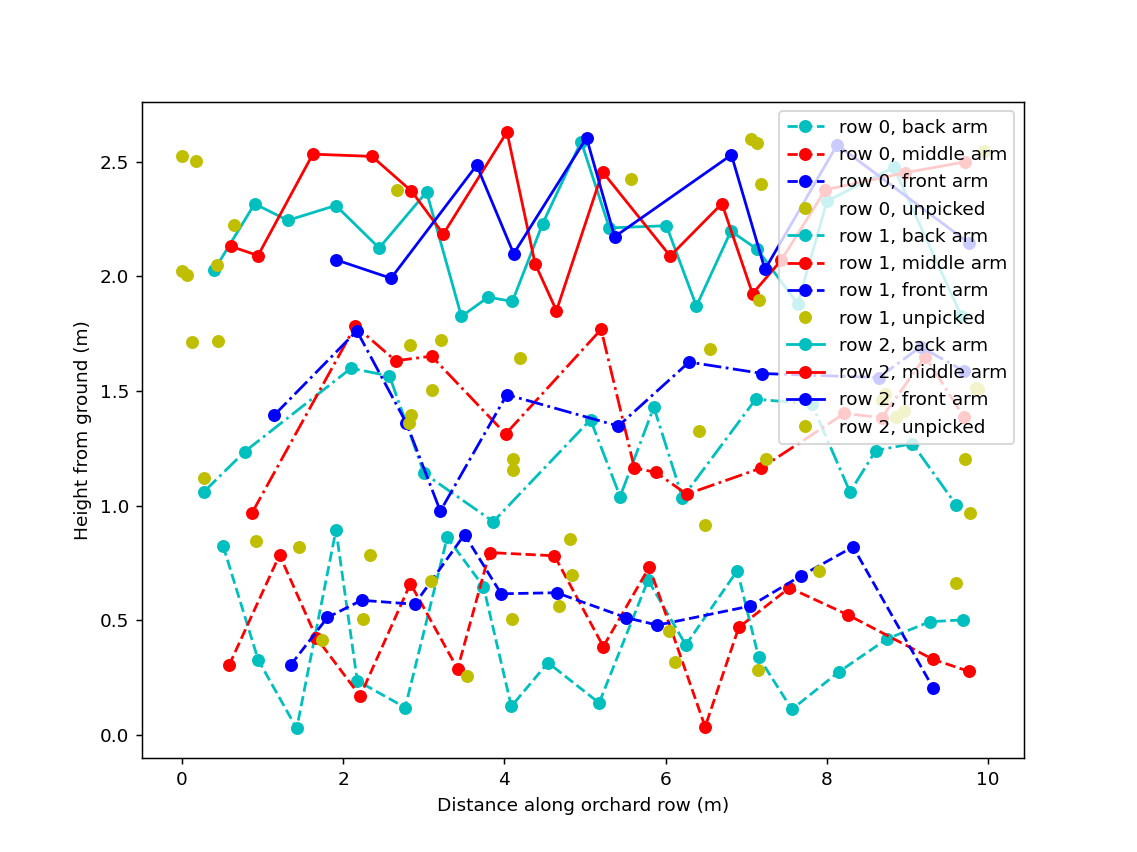

In [13]:
fig, ax = plt.subplots()

## row 0
plt.plot(sortedFruit[1][fruit_picked_by[0][0]], 
         sortedFruit[2][fruit_picked_by[0][0]], 'o--c', label='row 0, back arm')

plt.plot(sortedFruit[1][fruit_picked_by[0][1]], 
         sortedFruit[2][fruit_picked_by[0][1]], 'o--r',  label='row 0, middle arm')

plt.plot(sortedFruit[1][fruit_picked_by[0][2]], 
         sortedFruit[2][fruit_picked_by[0][2]], 'o--b',  label='row 0, front arm')

plt.plot(sortedFruit[1][fruit_picked_by[0][3]], 
         sortedFruit[2][fruit_picked_by[0][3]], 'oy',  label='row 0, unpicked')
## row 1
plt.plot(sortedFruit[1][fruit_picked_by[1][0]], 
         sortedFruit[2][fruit_picked_by[1][0]], 'o-.c', label='row 1, back arm')

plt.plot(sortedFruit[1][fruit_picked_by[1][1]], 
         sortedFruit[2][fruit_picked_by[1][1]], 'o-.r',  label='row 1, middle arm')

plt.plot(sortedFruit[1][fruit_picked_by[1][2]], 
         sortedFruit[2][fruit_picked_by[1][2]], 'o-.b',  label='row 1, front arm')

plt.plot(sortedFruit[1][fruit_picked_by[1][3]], 
         sortedFruit[2][fruit_picked_by[1][3]], 'oy',  label='row 1, unpicked')

## row 2
plt.plot(sortedFruit[1][fruit_picked_by[2][0]], 
         sortedFruit[2][fruit_picked_by[2][0]], 'o-c', label='row 2, back arm')

plt.plot(sortedFruit[1][fruit_picked_by[2][1]], 
         sortedFruit[2][fruit_picked_by[2][1]], 'o-r',  label='row 2, middle arm')

plt.plot(sortedFruit[1][fruit_picked_by[2][2]], 
         sortedFruit[2][fruit_picked_by[2][2]], 'o-b',  label='row 2, front arm')

plt.plot(sortedFruit[1][fruit_picked_by[2][3]], 
         sortedFruit[2][fruit_picked_by[2][3]], 'oy',  label='row 2, unpicked')

plt.xlabel('Distance along orchard row (m)')
plt.ylabel('Height from ground (m)')

legend = ax.legend(loc='upper right')
                   
plt.show()

In [8]:
# '''
#    Creating time intervals for each fruit for each arm in the cell based on fruit location: when the arm 
#    can pick it and how long extension+grab+retract+drop off of fruit will take. 
# '''

# edge_list = list()
# k_edges   = list()
# Tw_values = list() # the same value for every arm, separated into Tw0 (extend+grab) and Tw1 (retract+drop off)

# # calculate the time intervals describing when the arm would be busy picking each fruit (n_arm * numFruit)
# for index, y_i in enumerate(sortedFruit[1]):
#     # calculate y_i / v which is constant for this fruit
    
#     # handling time will not be constant here
#     [Tw0, Tw1] = calcTd(traj_calc, sortedFruit[0, index], sortedFruit[2, index])
#     Tw_values.append([Tw0, Tw1]) # save values since it will be used to calc picking time later
    
#     Tw = Tw0 + Tw1
    
#     # values of fruit location at the start and end, as well as the handling time
#     t_start_0 = y_i / v - Tw # adding the calculated handling time 
#     t_end_0   = y_i / v      # the end time will be when the back frame is reached by the fruit 
    
#     k_edges.append(index)
    
#     for k in range(n_arm):
#         # add the offset based on the arm number (assuming back arm is k=0 to front arm k=n_arm)
# #         offset = (cell_l*(k+1)) / v  # (k+1) to indicate it's the front frame location we're looking for
#         offset = (cell_l*k) / v  # looking at the back part of the frame 
        
#         ## Saying here that the fruit can only be picked if arm is not busy when the front of the frame reaches t
#         #  the fruit
        
#         t_start_k = t_start_0 - offset
#         t_end_k   = t_end_0 - offset
        
#         ### NOTE: check if interval too long versus the amount of time fruit is in cell (t = cell_l/v)      
#         if t_start_k > 0 and t_end_k > 0 and t_end_k - (t_start_k + Tw0) < cell_l/v:
#             # the interval has to be positive or it cannot be used (impossible to pick that fruit)
#             k_edges.append([k, t_start_k, t_end_k])
            
    
#     if len(k_edges) > 1:
# #         print(k_edges)
#         edge_list.append(k_edges.copy()) # if not a copy, values in edge_list also get deleted in next line
    
#     # delete values in k_edges
#     del k_edges[:]
    
# print(edge_list)

[[2, [0, 2.7536066655136175, 6.679069586827957]], [3, [0, 8.890002489782287, 12.480147626250936]], [4, [0, 13.257002845953977, 17.802418167642497]], [5, [0, 23.540718986237017, 26.944292385864376]], [6, [0, 23.64905735458389, 28.085998402378575]], [7, [0, 35.28430571970428, 40.00844479907584], [1, 5.284305719704278, 10.00844479907584]], [8, [0, 40.05211753158301, 43.98952086020258], [1, 10.052117531583008, 13.989520860202582]], [9, [0, 41.41045705865932, 45.37611805700104], [1, 11.410457058659318, 15.376118057001037]], [10, [0, 47.066474441288115, 51.186010045683126], [1, 17.066474441288115, 21.186010045683126]], [11, [0, 56.29766883852635, 58.491705953014446], [1, 26.29766883852635, 28.491705953014446]], [12, [0, 56.12805442896551, 60.87745297970471], [1, 26.128054428965513, 30.877452979704707]], [13, [0, 59.336713668462934, 64.82209209449796], [1, 29.336713668462934, 34.82209209449796]], [14, [0, 74.46535266037452, 77.93435332740006], [1, 44.46535266037452, 47.93435332740006], [2, 14

In [9]:
# '''now have to figure out which arm picks what based on time intervals'''
# ## ASSUMES: arm ready to pick instantly after finishing picking last fruit (no movement time needed)


# # (b) process nodes in order of increasing y-coord
# # Td = np.zeros(n_arm)
# t  = np.zeros([n_arm, numFruit+1]) # t of arm k when *finished picking* (Tm+Td) fruit i

# # save Tm values for state % plot
# Tm_values = list()

# for k in range(n_arm):
#     Tm_values.append([])

# # update this for when there are more than three arms
# last_i = np.array([node_array[0], node_array[1], node_array[2]]) # saves the fruit id of the fruit last picked by the arm k 
# curr_j = np.array([node_array[0].j, node_array[1].j, node_array[2].j]) # saves the number of fruit being picked by 
# # the kth arm

# for e in edge_list:
#     i   = e[0] ## causes below k+1 because e[0] is i (fruit num)
    
#     for k in range(len(e)-1):
#         # the arm number (changes based on how many intervals had negative values) 
#         # => not all arms could pick fruit
# #         print('arm number', k)
# #         print('start:', e[k+1][1], 'end:', e[k+1][2]) 
        
#         # take the previously chosen i for arm k and add in the move time to new i
#         prev = sortedFruit[1, last_i[k].i] 
#         # calculate how far the vehicle moves between the interval end of y_(i-1) and interval start of y_i
#         # also removes the Td/Tw after picking value (won't move in y after that)
#         veh_move = (e[k+1][1] - (last_i[k].t - Tw_values[i][1]))*v  
        
#         # move to new location arrived when moving to get the next fruit
#         # ends in line with previous fruit plus the distance the vehicle moves between the end time of last fruit
#         # and the beginning time of this one
#         start_y = prev #+ veh_move      
#         start_z = 0.                          # ends at the bottom to drop off the fruit
        
#         print('y_(i-1):', prev, 'y_i:', sortedFruit[1,i])
#         print('new y(i-1):', start_y, 'since vehicle moves:', veh_move)
        
#         # new fruit's location
#         fruit_y = sortedFruit[1,i]
#         fruit_z = sortedFruit[2,i]
        
#         # calculate how long it would take to reach new fruit
#         Tm = calcTm(traj_calc, start_y, start_z, fruit_y, fruit_z)
        
#         start_time = e[k+1][1] - Tm # add movement into work before handling to get the true total time interval
        
#         # careful with reference, the return should actually be ((u,v), begin, end)
#         # https://dynetworkx.readthedocs.io/en/latest/reference/classes/generated/dynetworkx.IntervalGraph.edges.html#dynetworkx.IntervalGraph.edges              
#         n_interval = IG.edges(begin=start_time, end=e[k+1][2]) # check if there are edges that lie between the new edges?
#         print('number of intervals that fall within the current calculated edges',len(n_interval))

#         is_busy    = IG.edges(v=last_i[k], begin=start_time, end=e[k+1][2])
#         print('is arm', k, 'already busy for this interval?', len(is_busy))
            
#         if len(n_interval) < n_arm and len(is_busy) < 1: 
#             # add an edge between the last node and this node with interval edge U
#             print('      add edge')
# #             IG.add_edge(last_i[k], node_array[i+n_arm], e[k+1][1], e[k+1][2])
#             IG.add_edge(last_i[k], node_array[i+n_arm], start_time, e[k+1][2])

#             # update the node
#             node_array[i+n_arm].j = curr_j[k] + 1
#             node_array[i+n_arm].k = k
#             node_array[i+n_arm].t = e[k+1][2] 
            
#             # save the Tm value for state plot
#             Tm_values[k].append(Tm)

#             # update all the saved prev node data
#             last_i[k] = node_array[i+n_arm]
#             curr_j[k] = node_array[i+n_arm].j # maybe don't need to save this array, just use last_i

#             # skip this fruit for the rest of the arms
#             print()
#             break

y_(i-1): 0.005292470942258598 y_i: 0.06679069586827957
new y(i-1): 0.005292470942258598 since vehicle moves: 0.0605025240296324
number of intervals that fall within the current calculated edges 0
is arm 0 already busy for this interval? 0
      add edge

y_(i-1): 0.06679069586827957 y_i: 0.12480147626250937
new y(i-1): 0.06679069586827957 since vehicle moves: 0.05156531853641539
number of intervals that fall within the current calculated edges 1
is arm 0 already busy for this interval? 1
y_(i-1): 0.06679069586827957 y_i: 0.17802418167642498
new y(i-1): 0.06679069586827957 since vehicle moves: 0.1049420482642685
number of intervals that fall within the current calculated edges 0
is arm 0 already busy for this interval? 0
      add edge

y_(i-1): 0.17802418167642498 y_i: 0.26944292385864377
new y(i-1): 0.17802418167642498 since vehicle moves: 0.08180751952164389
number of intervals that fall within the current calculated edges 0
is arm 0 already busy for this interval? 0
      add edge



number of intervals that fall within the current calculated edges 3
is arm 2 already busy for this interval? 0
y_(i-1): 6.4892486262989095 y_i: 6.697894407321031
new y(i-1): 6.4892486262989095 since vehicle moves: 0.19410125104222062
number of intervals that fall within the current calculated edges 0
is arm 0 already busy for this interval? 0
      add edge

y_(i-1): 6.697894407321031 y_i: 6.809574365288532
new y(i-1): 6.697894407321031 since vehicle moves: 0.0980308578262509
number of intervals that fall within the current calculated edges 0
is arm 0 already busy for this interval? 0
      add edge

y_(i-1): 6.809574365288532 y_i: 6.815500575118004
new y(i-1): 6.809574365288532 since vehicle moves: -0.008309803380765288
number of intervals that fall within the current calculated edges 1
is arm 0 already busy for this interval? 1
y_(i-1): 6.4895619636689155 y_i: 6.815500575118004
new y(i-1): 6.4895619636689155 since vehicle moves: 0.31170259823885205
number of intervals that fall withi

In [10]:
# print('Total number of fruit:', numFruit)
# print('Total harvested fruit:', np.sum(curr_j), 'or', np.sum(curr_j)/numFruit, '%')
# print('Number of fruit picked by arm 0:', curr_j[0], 'arm 1:', curr_j[1], 'arm 2:', curr_j[2])

Total number of fruit: 189
Total harvested fruit: 165 or 0.873015873015873 %
Number of fruit picked by arm 0: 98 arm 1: 52 arm 2: 15


In [11]:
# IG.edges()

# fruit_picked_by = list()
# for k in range(n_arm+1):
#     fruit_picked_by.append([])

# for i in range(n_arm, numFruit+n_arm):
#     fruit_picked_by[node_array[i].k].append(node_array[i].i)

# print(fruit_picked_by)

[[2, 4, 5, 7, 10, 11, 14, 15, 19, 20, 21, 22, 24, 26, 27, 28, 29, 30, 33, 35, 37, 40, 42, 43, 45, 47, 51, 54, 55, 57, 60, 63, 64, 66, 68, 69, 71, 72, 73, 74, 77, 83, 84, 85, 86, 87, 90, 91, 93, 95, 96, 99, 100, 102, 104, 106, 107, 109, 111, 112, 113, 115, 116, 117, 120, 122, 125, 126, 128, 130, 133, 137, 142, 144, 145, 146, 148, 149, 150, 152, 153, 155, 156, 158, 159, 161, 164, 166, 167, 169, 170, 172, 174, 175, 177, 183, 186, 188], [8, 12, 16, 23, 25, 31, 34, 36, 38, 41, 44, 48, 56, 59, 61, 65, 67, 70, 75, 78, 88, 92, 94, 97, 101, 103, 105, 108, 110, 114, 118, 121, 123, 127, 129, 131, 135, 143, 147, 151, 154, 157, 160, 163, 165, 168, 171, 173, 176, 178, 184, 187], [17, 32, 46, 49, 58, 62, 76, 80, 89, 119, 132, 136, 162, 179, 185], [0, 1, 3, 6, 9, 13, 18, 39, 50, 52, 53, 79, 81, 82, 98, 124, 134, 138, 139, 140, 141, 180, 181, 182]]


For arm 0
idle: 47.87531984638787 pick_yz: 16.510856409140654 pick_x 9.070968582804758 grab: 0.9799999999999981 retract_x: 9.070968582804758 unload: 16.491886578861966
Sum total of all percentages 100.0

For arm 1
idle: 67.84927820290405 pick_yz: 11.000082687188145 pick_x 4.828725402603504 grab: 0.5199999999999997 retract_x: 4.828725402603504 unload: 10.973188304700807
Sum total of all percentages 100.00000000000001

For arm 2
idle: 90.37740741788555 pick_yz: 3.2300607057938384 pick_x 1.515898003407161 grab: 0.15000000000000002 retract_x: 1.515898003407161 unload: 3.2107358695062924
Sum total of all percentages 100.0



<IPython.core.display.Javascript object>


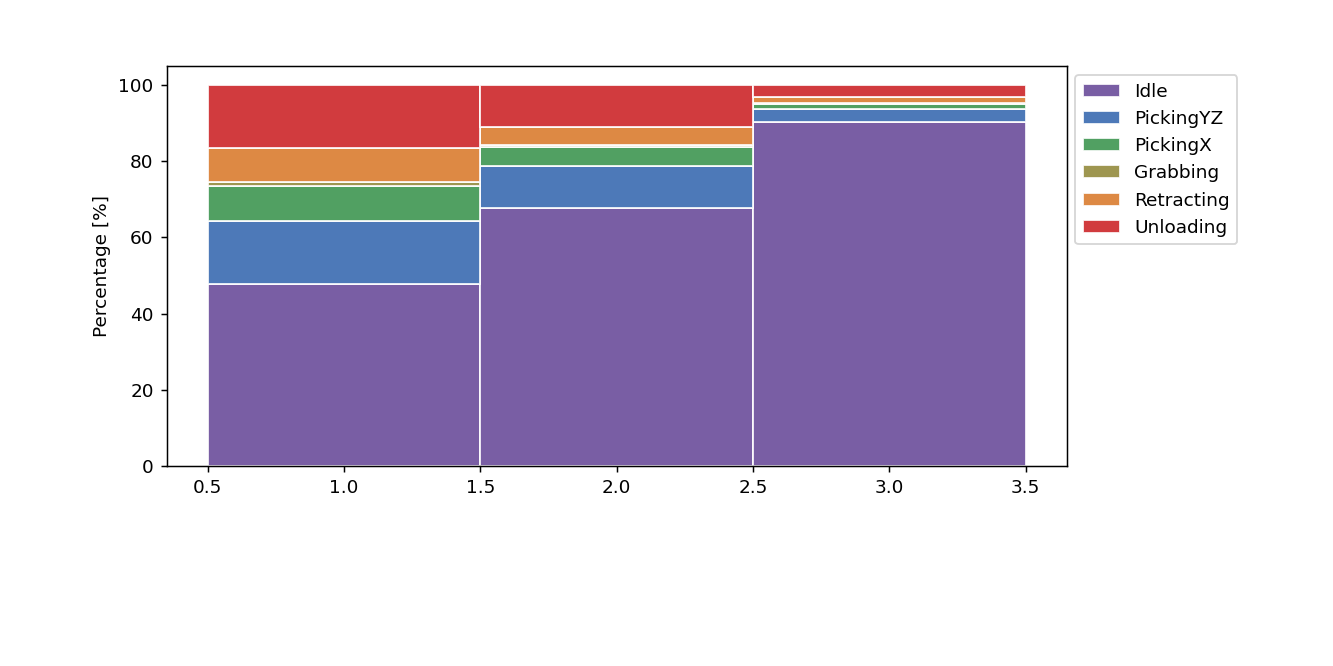

In [13]:
'''Plot the percent time each arm is in each state'''
total_time = (y_lim[1] - y_lim[0]) / v

## states: idle, pick_yz, pick_x, grab, retract_x, move_z/unload
state_percent = np.zeros([n_arm, 6]) # save each arm's percent time in each of the six states 

for k in range(n_arm):
    # calculate arm's move_yz using Tm
    for tm in Tm_values[k]:
        state_percent[k,1] += tm
    
    for i in fruit_picked_by[k]:  
#         print(Tw_values[i])
        
        # calculate extend from Tw0 and final j for each arm k       
        move_x = Tw_values[i][0] - t_grab
        state_percent[k,2] += move_x

        # calculate grab from Tw and final j for each arm k
        state_percent[k,3] += t_grab

        # calculate unload from Tw1 and final j for each arm k
        state_percent[k,5] += Tw_values[i][1] - move_x
    
    # since this is ideal, retract == extend
    state_percent[k,4] = state_percent[k,2]
    
    # calculate idle by subtracting all before by total time: length_row / v
    state_percent[k,0] = total_time - np.sum(state_percent[k,:])
    
    state_percent[k,:] = (state_percent[k,:] / total_time) * 100
    
    print('For arm', k,)
    print('idle:', state_percent[k,0], 'pick_yz:', state_percent[k,1], 'pick_x', state_percent[k,2], 'grab:',
          state_percent[k,3], 'retract_x:', state_percent[k,4], 'unload:', state_percent[k,5])

    # does each k's state % add up to 100%?
    percent_sum = np.sum(state_percent[k,:])
    print('Sum total of all percentages', percent_sum)
    print()
    
state_percent_transpose = state_percent
    
state_percent_list = state_percent_transpose.tolist()
# print(state_percent_list)
plot_states = plotStates(state_percent_list)


<IPython.core.display.Javascript object>


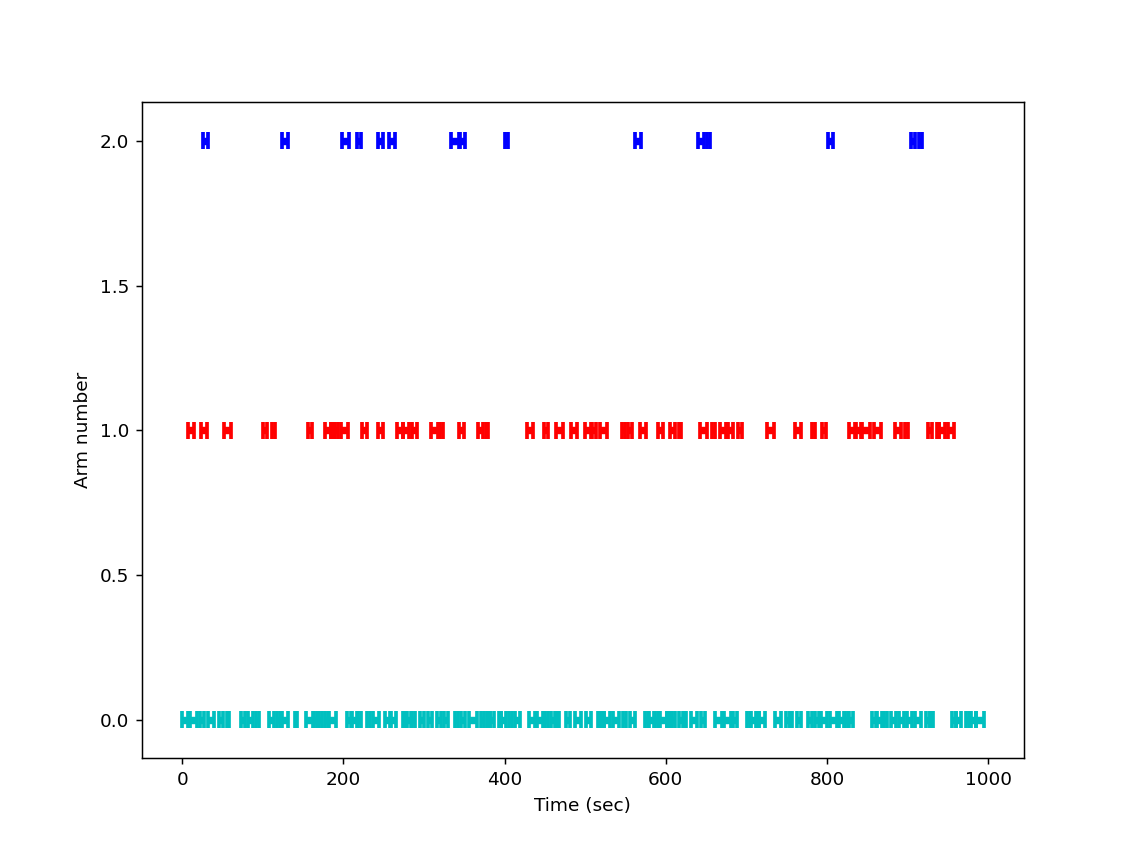

In [13]:
'''Plot the intervals -- Testing time not distance intervals'''
# based on https://stackoverflow.com/questions/7684475/plotting-labeled-intervals-in-matplotlib-gnuplot

# plot is based on time...
fig, ax = plt.subplots()

for e in IG.edges():
    if e[1].k == 0:
        intervalGraph(e[1].k, e[2], e[3], color='c')
    elif e[1].k == 1:
        intervalGraph(e[1].k, e[2], e[3], color='r')
    elif e[1].k == 2:
        intervalGraph(e[1].k, e[2], e[3], color='b')

plt.xlabel('Time (sec)')
plt.ylabel('Arm number')
        
plt.show()

<IPython.core.display.Javascript object>


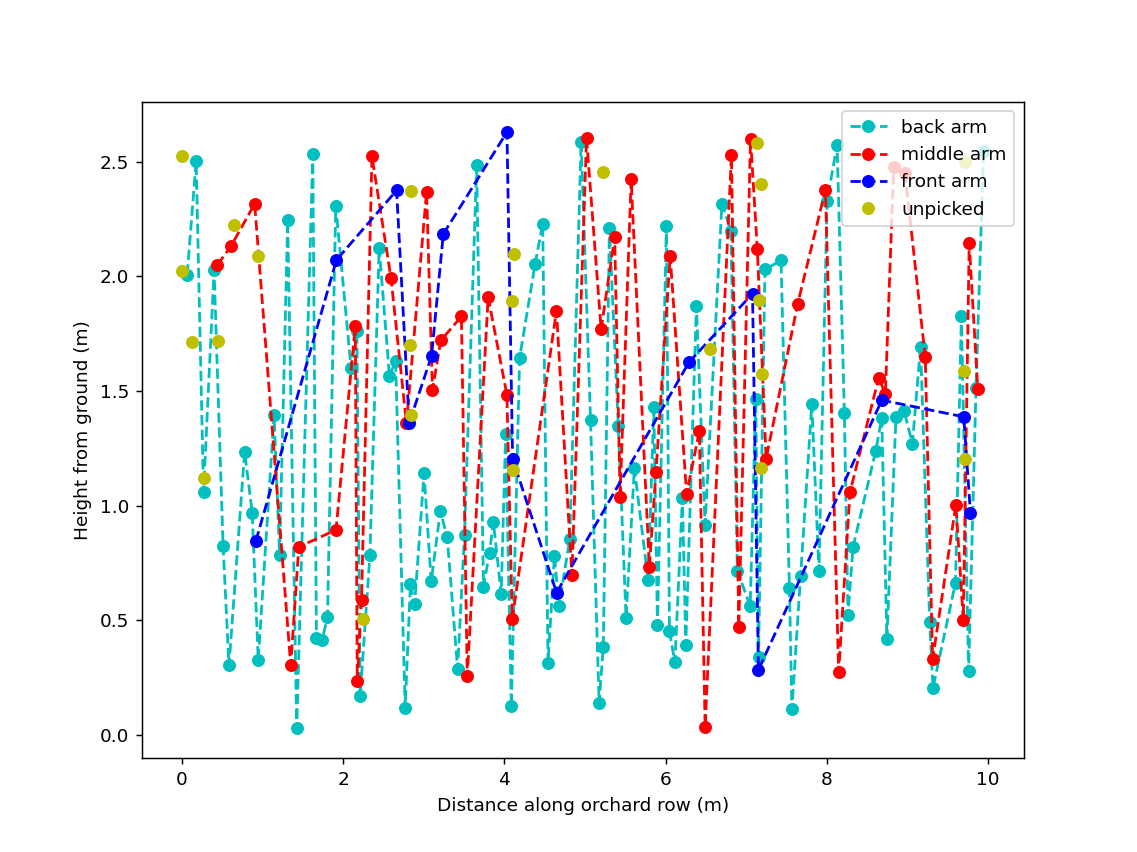

In [14]:
# fig, ax = plt.subplots()

# plt.plot(sortedFruit[1][fruit_picked_by[0]], 
#          sortedFruit[2][fruit_picked_by[0]], 'o--c', label='back arm')

# plt.plot(sortedFruit[1][fruit_picked_by[1]], 
#          sortedFruit[2][fruit_picked_by[1]], 'o--r',  label='middle arm')

# plt.plot(sortedFruit[1][fruit_picked_by[2]], 
#          sortedFruit[2][fruit_picked_by[2]], 'o--b',  label='front arm')

# plt.plot(sortedFruit[1][fruit_picked_by[3]], 
#          sortedFruit[2][fruit_picked_by[3]], 'oy',  label='unpicked')

# plt.xlabel('Distance along orchard row (m)')
# plt.ylabel('Height from ground (m)')

# legend = ax.legend(loc='upper right')
                   
# plt.show()

<IPython.core.display.Javascript object>


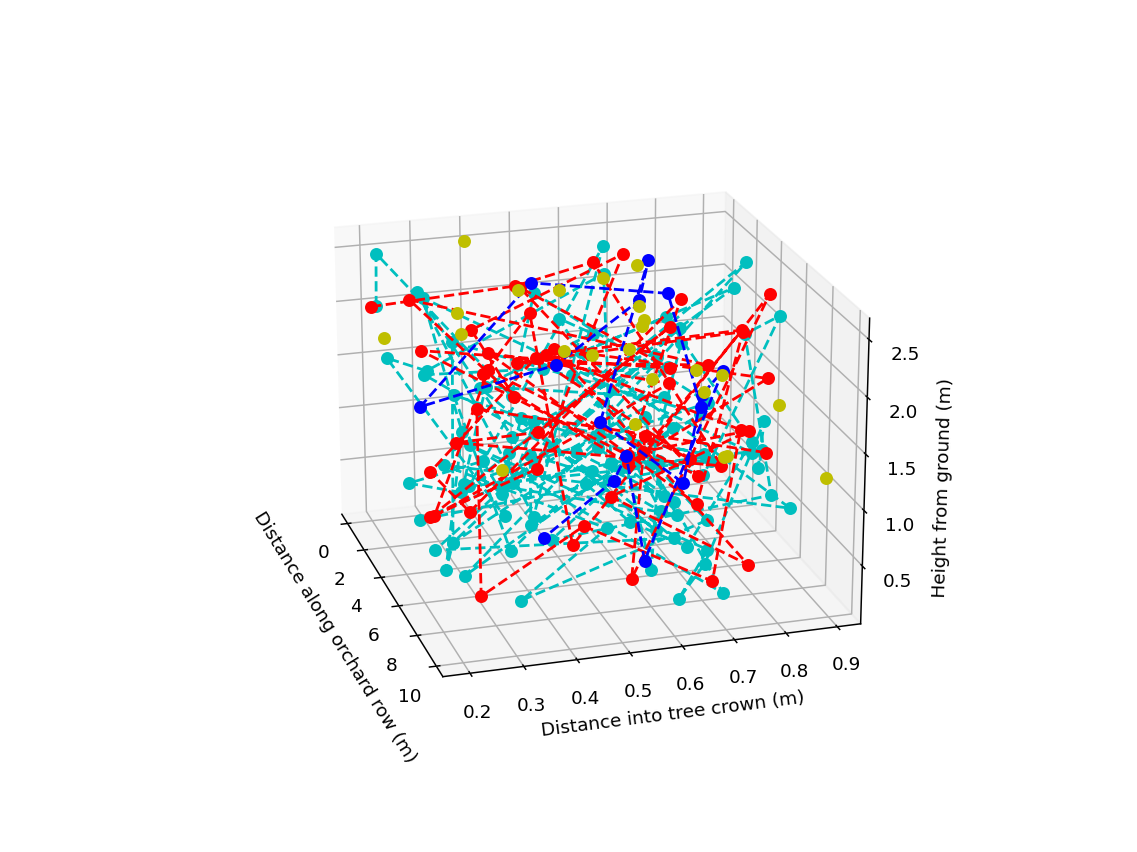

In [15]:
fig = plt.figure()
ax = plt.axes(projection ='3d')

plt.plot(sortedFruit[1][fruit_picked_by[0]], sortedFruit[0][fruit_picked_by[0]], sortedFruit[2][fruit_picked_by[0]], 'o--c')
plt.plot(sortedFruit[1][fruit_picked_by[1]], sortedFruit[0][fruit_picked_by[1]], sortedFruit[2][fruit_picked_by[1]], 'o--r')
plt.plot(sortedFruit[1][fruit_picked_by[2]], sortedFruit[0][fruit_picked_by[2]], sortedFruit[2][fruit_picked_by[2]], 'o--b')
plt.plot(sortedFruit[1][fruit_picked_by[3]], sortedFruit[0][fruit_picked_by[3]], sortedFruit[2][fruit_picked_by[3]], 'oy')


ax.set_xlabel('Distance along orchard row (m)')
ax.set_ylabel('Distance into tree crown (m)')
ax.set_zlabel('Height from ground (m)')

plt.show()